In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Failed')
    # Invalid device or cannot modify virtual devices once initialized.
    pass

### Importing And Cleaning

In [2]:
import os
input_dir='images/img'
target_dir='annotations/trimaps/img'
img_size=(160,160)
num_classes=3
batch_size=32

input_image_paths=sorted(
[
    os.path.join(input_dir,fname)
    for fname in os.listdir(input_dir)
    if fname.endswith('.jpg')
])
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

for input_path, target_path in zip(input_image_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)
garbage_files=sorted(os.path.join(target_dir,fname) for fname in os.listdir(target_dir) if fname.startswith("."))

images/img\Abyssinian_1.jpg | annotations/trimaps/img\Abyssinian_1.png
images/img\Abyssinian_10.jpg | annotations/trimaps/img\Abyssinian_10.png
images/img\Abyssinian_100.jpg | annotations/trimaps/img\Abyssinian_100.png
images/img\Abyssinian_101.jpg | annotations/trimaps/img\Abyssinian_101.png
images/img\Abyssinian_102.jpg | annotations/trimaps/img\Abyssinian_102.png
images/img\Abyssinian_103.jpg | annotations/trimaps/img\Abyssinian_103.png
images/img\Abyssinian_104.jpg | annotations/trimaps/img\Abyssinian_104.png
images/img\Abyssinian_105.jpg | annotations/trimaps/img\Abyssinian_105.png
images/img\Abyssinian_106.jpg | annotations/trimaps/img\Abyssinian_106.png
images/img\Abyssinian_107.jpg | annotations/trimaps/img\Abyssinian_107.png


In [3]:
for i in garbage_files:
    os.remove(i)

In [4]:
len(target_img_paths)==len(input_image_paths)

True

### Visualizing

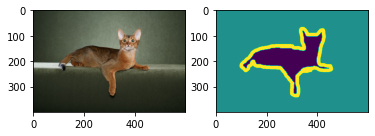

In [5]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(np.array(PIL.Image.open(input_image_paths[0])))
fig.add_subplot(1,2,2)
plt.imshow(np.array(PIL.Image.open(target_img_paths[0])))

### Generator Class

In [6]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [7]:
train_gen = OxfordPets(
    batch_size, img_size, input_image_paths,target_img_paths
)

### The U-NET Model

In [8]:
from tensorflow import keras
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.fit(train_gen, epochs=10)

Epoch 1/10
230/230 [==============================] - 53s 182ms/step - loss: 1.9883
Epoch 2/10
230/230 [==============================] - 42s 183ms/step - loss: 0.5893
Epoch 3/10
230/230 [==============================] - 43s 185ms/step - loss: 0.47630s - loss: 0
Epoch 4/10
230/230 [==============================] - 42s 184ms/step - loss: 0.4188
Epoch 5/10
230/230 [==============================] - 43s 185ms/step - loss: 0.3818
Epoch 6/10
230/230 [==============================] - 43s 185ms/step - loss: 0.3479
Epoch 7/10
230/230 [==============================] - 43s 186ms/step - loss: 0.3208
Epoch 8/10
230/230 [==============================] - 43s 186ms/step - loss: 0.2921
Epoch 9/10
230/230 [==============================] - 43s 187ms/step - loss: 0.2803
Epoch 10/10
230/230 [==============================] - 43s 187ms/step - loss: 0.2587


In [14]:
model.save("Unet.h5")

### Predictions On a Single Test Set

In [10]:
test_prediction=np.array(PIL.Image.open(input_image_paths[0]).resize((160,160)))
test_prediction=test_prediction.reshape(1,160,160,3)

In [11]:
test=model.predict(test_prediction)

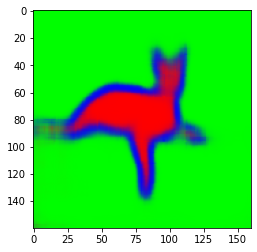

In [12]:
plt.imshow(test[0,:,:,:])